# NV Center - Weak measurement nuclear magnetic resonance

The NV center is the most well studied crystallographic defect in diamond. It has a spin triplet ground state and can be used as an atomic-sized sensor for magnetic and electric fields. NV centers have been used to perform nanoscale NMR measurements of proximal nuclei both within the diamond lattice and, when within several nm of the surface, external nuclei in chemical species. The NV center is further capable of detecting the free induction decay of nearby nuclear spins using a measurement technique referred to as weak measurements. Here, the nuclear spin is polarized and rotated with a pi/2 pulse to initiate precession. Repeated weak measurements on the NV center, consisting of optical spin initialization, XY-8 dynamical decoupling frequency encoding, and optical readout are used to track the nuclear spin precession.

The nuclear spin is coupled to the NV center through the hyperfine interaction $H_\mathrm{int}$ and the complete system Hamiltonian is given by
$$
H = H_\mathrm{NV} + H_\mathrm{nuc} + H_\mathrm{int} = D S_z^2 + \gamma_e B_z S_z + \gamma_n B_z I_z + H_\mathrm{int},
$$
where $B_z$ denotes the magnetic field along the NV axis, $S_z$ and $I_z$ are the $z$-components of the NV center and nuclear spin operators, respectively, and $S_x$ and $I_x$ are the $x$-components of the NV center and nuclear spin operators, respectively. 

In this notebook we showcase how to implement the following experiment:
1. Transfer Polarization from the NV center to the nuclear spin.
2. Induce an FID precession of the nuclear spin via the RF field.
3. Sample the nuclear spin precession by repetitive weak measurements of the NV center.

In [ ]:
import simos as sos
import numpy as np
import matplotlib.pyplot as plt

In a first step we initialise the quantum system of a single NV center coupled to a single carbon spin. We neglect all optical dynamics of the NV center in this example.  We can either do so by hand ... 

In [ ]:
system_def = []
system_def.append({'name':'S','type':'NV','val':1})
system_def.append({'name':'I','type':'13C','val':1/2,'pol':1.0})
s = sos.System(system_def)

... or by simply using the high-level NVSystem function of the NV submodule.

In [ ]:
C= {'name':'I','type':'13C','val':1/2,'pol':1.0}
s = sos.NV.NVSystem(further_spins = [C], optics = False, nitrogen = False)

We have now the spin operators of the product space of the NV center and the nuclear spin at hand, e.g. we can extract the x-operator of the carbon spin as:

In [ ]:
print(s.Ix)

Quantum object: dims=[[3, 2], [3, 2]], shape=(6, 6), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.  0.5 0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.5 0. ]]


For our experiment, the NV center is driven by a microwave field. To simplify calculations, we go to the rotating frame of the microwave field resonant with one of the two transitions. The Hamiltonian in the rotating frame is given by
$$
H_0 = \gamma_n B_z I_z +  a_\parallel S_z I_z  + a_\perp S_z I_x
$$

In [ ]:
apara = sos.f2w(1e3)
aperp = sos.f2w(100e3)
B0 = 200e-3 #magnetic field
H0 = sos.yC13*B0*s.Iz + apara*s.Sz*s.Iz + aperp*s.Sx*s.Ix

To perform (infinitely fast) rotations on the NV center, we can use the ``rot`` function of the ``simos`` library. For the NV center, this is somehow special: As we are resonant with only one of the two transitions, we have to use modified rotation operators that are effective spin-1/2 operators in the spin-1 Hilbert space. Luckily, the ``simos`` library provides these operators automatically when we specify the ``type`` of the spin in the system definition as ``NV``. Then, besides the $S_x$, $S_y$, and $S_z$ operators, the library also provides the effective $S_{x,\mathrm{red}}$ and $S_{x,\mathrm{red2}}$ operators.

In [ ]:
print(s.Sop_x_red)

Quantum object: dims=[[3, 2], [3, 2]], shape=(6, 6), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0. ]]



We use the microwave field to perform rotations on the NV center. To actuate the nuclear spin, an additional radio-frequency (RF) field is applied perpendicular to the NV axis. The RF field is resonant with the nuclear spin transition. We will treat this in the laboratory frame. Thus, the RF Hamiltonian is given by
$$
H_\mathrm{RF} = \gamma_n B_\mathrm{max} I_x \cos(\omega_\mathrm{RF} t),
$$
where $B_\mathrm{max}$ is the amplitude of the RF field and $\omega_\mathrm{RF}=\gamma_n B_z$ is the frequency of the RF field. Hereby, we treat the $\cos$ part of the RF Hamiltonian as a time-dependent modulation part of the Hamiltonian. We can then use the the ``prop`` routine of the ``simos`` library to propagate the system under the Hamiltonian.

In [ ]:
# nuclear rabi frequency
Orf = sos.f2w(100e3)
Hrf = 2*Orf*s.Ix # x2 because of RWA
frf = sos.w2f(B0*sos.yC13)

The inital state of the NV center - nuclear spin system after the polarization transfer is given by rho0 which is rotated by a pi/2 pulse to obtain the actual initial precessing state rho1

In [ ]:
rho0 = sos.NV.gen_rho0(s)

In [ ]:
#rho1 = sos.lab_squarepulse(H0,Hrf,frf,0,1,2.5e-6,rho0)
rho1 = sos.rot(s.Ix,np.pi/2,rho0)   

What the ``lab_squarepulse`` function does is to apply a square pulse of the RF field for a certain duration. The function takes the system, the duration of the pulse, and the amplitude of the RF field as input. The function returns the system after the pulse. To see this on a more low-level view, the function uses the ``prop`` routine of the ``simos`` library to propagate the system under the RF Hamiltonian. However, optimizations are done to speed up the calculation.

We can now perform the detection phase of the experiment by performing weak measurements on the NV center. The weak measurement is performed by a dynamical decoupling sequency (e.g. XY8).

In [ ]:
Nreadouts = 500
twait = 0.125/frf
tau = 1/frf/2
store = []
rho = rho1.copy()
for i in range(Nreadouts):
    rho = sos.rot(s.Sop_y_red,np.pi/2,rho)
    rho = sos.NV.XY8(H0,tau,s,rho,N=16)
    rho = sos.rot(s.Sop_x_red,np.pi/2,rho)
    meas,rho = sos.NV.meas_NV(rho,s)
    store.append(meas)

    rho = sos.evol(H0,twait,rho)

Tsample = 16*tau + twait
foffset = np.round(Tsample*frf)/Tsample

The ``store`` array now contains the (inherently undersampled) free induction decay (FID) of the nuclear spin. We can now perform a Fourier transform to obtain the spectrum of the nuclear spin.

Text(0, 0.5, 'NV signal $\\langle S_z \\rangle$')

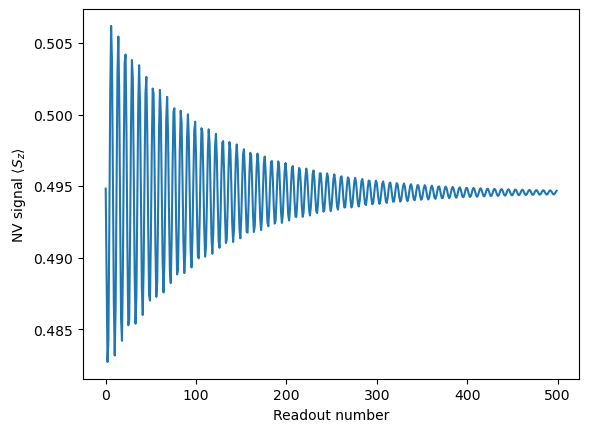

In [ ]:
plt.plot(store)
plt.xlabel('Readout number')
plt.ylabel('NV signal $\\langle S_z \\rangle$')

Text(0, 0.5, 'PSD (a.u.)')

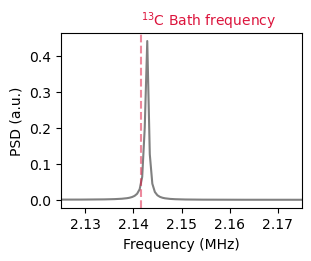

In [ ]:
fax,fft = sos.ffthelper(store,Tsample,dc_block=True,real_input=True)
fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")
ax.plot((foffset+fax)*1e-6,fft, color = "grey")
ax.axvline(frf*1e-6,color='crimson',alpha=0.5,linestyle='--')
ax.text(frf*1e-6,0.47,'$^{13}$C Bath frequency',rotation=0,verticalalignment='bottom',color='crimson')
ax.set_xlabel('Frequency (MHz)')
ax.set_xlim([2.125, 2.175])
ax.set_ylabel('PSD (a.u.)')